In [2]:
# Boring preliminaries
import re
import math
import string
from collections import Counter
from __future__ import division

<center>
<h1>Statistical Natural Language Processing in Python.
<br><font color=blue>or</font>
<br>How To Do Things With Words.  And Counters.
<br><font color=blue>or</font>
<br>Everything I Needed to Know About NLP I learned From Sesame Street.
<br>Except Kneser-Ney Smoothing.
<br>The Count Didn't Cover That.
<br>
<br><img src='http://norvig.com/ipython/the-count.jpg'> 
<br>*One, two, three, ah, ah, ah!* &mdash; The Count
</center>
<hr>

(1) Data: Text and Words
========

Before we can do things with words, we need some words.  First we need some *text*, possibly from a *file*.  Then we can break the text into words.  I happen to have a big text called [big.txt](file:///Users/pnorvig/Documents/ipynb/big.txt).  We can read it, and see how big it is (in characters):

In [3]:
TEXT = file('big.txt').read()
len(TEXT)

6488409

So, six million characters.

Now let's break the text up into words (or more formal-sounding, *tokens*).  For now we'll ignore all the punctuation and numbers, and anything that is not a letter.

In [4]:
def tokens(text):
    "List all the word tokens (consecutive letters) in a text. Normalize to lowercase."
    return re.findall('[a-z]+', text.lower()) 

In [5]:
tokens('This is: A test, 1, 2, 3, this is.')

['this', 'is', 'a', 'test', 'this', 'is']

In [9]:
WORDS = tokens(TEXT)
len(WORDS)

1105211

So, a million words.  Here are the first 10:



In [10]:
print(WORDS[:10])

['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'adventures', 'of', 'sherlock', 'holmes']


(2) Models: Bag of Words
====

The list `WORDS` is a list of the words in the `TEXT`, but it can also serve as a *generative model* of text. We know that language is very complicated, but we can create a simplified model of language that captures part of the complexity.  In the *bag of words* model, we ignore the order of words, but maintain their frequency.  Think of it this way: take all the words from the text, and throw them into a bag.  Shake the bag, and then generating a sentence consists of pulling words out of the bag one at a time.  Chances are it won't be grammatical or sensible, but it will have words in roughly the right proportions.  Here's a function to sample an *n* word sentence from a bag of words:

In [11]:
def sample(bag, n=10):
    "Sample a random n-word sentence from the model described by the bag of words."
    return ' '.join(random.choice(bag) for _ in range(n))

In [12]:
sample(WORDS)

'the mucous acute ordered inevitability collision collection a attained august'

Another representation for a bag of words is a `Counter`, which is a dictionary of `{'word': count}` pairs.  For example,

In [13]:
Counter(tokens('Is this a test? It is a test!'))

Counter({'a': 2, 'is': 2, 'test': 2, 'this': 1, 'it': 1})

A `Counter` is like a `dict`, but with a few extra methods.  Let's make a `Counter` for the big list of `WORDS` and get a feel for what's there:

In [14]:
COUNTS = Counter(WORDS)

print COUNTS.most_common(10)

[('the', 80029), ('of', 40025), ('and', 38312), ('to', 28766), ('in', 22047), ('a', 21155), ('that', 12512), ('he', 12401), ('was', 11410), ('it', 10681)]


In [15]:
for w in tokens('the rare and neverbeforeseen words'):
    print COUNTS[w], w

80029 the
83 rare
38312 and
0 neverbeforeseen
460 words


In 1935, linguist George Zipf noted that in any big text, the *n*th most frequent word appears with a frequency of about 1/*n* of the most frequent word. He get's credit for *Zipf's Law*, even though Felix Auerbach made the same observation in 1913.  If we plot the frequency of words, most common first, on a log-log plot, they should come out as a straight line if Zipf's Law holds.  Here we see that it is a fairly close fit:

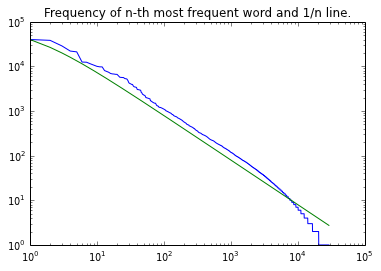

In [16]:
M = COUNTS['the']
yscale('log'); xscale('log'); title('Frequency of n-th most frequent word and 1/n line.')
plot([c for (w, c) in COUNTS.most_common()])
plot([M/i for i in range(1, len(COUNTS)+1)]);

(3) Task: Spelling Correction
========

Given a word *w*, find the most likely correction *c* = `correct(`*w*`)`.

**Approach:** Try all candidate words *c* that are known words that are near *w*.  Choose the most likely one.

How to balance *near* and *likely*?

For now, in a trivial way: always prefer nearer, but when there is a tie on nearness, use the word with the highest `WORDS` count.  Measure nearness by *edit distance*: the minimum number of deletions, transpositions, insertions, or replacements of characters. By trial and error, we determine that going out to edit distance 2 will give us reasonable results.  Then we can define `correct(`*w*`)`:
        
        


In [17]:
def correct(word):
    "Find the best spelling correction for this word."
    # Prefer edit distance 0, then 1, then 2; otherwise default to word itself.
    candidates = (known(edits0(word)) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or 
                  [word])
    return max(candidates, key=COUNTS.get)

The functions `known` and `edits0` are easy; and `edits2` is easy if we assume we have `edits1`:

In [18]:
def known(words):
    "Return the subset of words that are actually in the dictionary."
    return {w for w in words if w in COUNTS}

def edits0(word): 
    "Return all strings that are zero edits away from word (i.e., just word itself)."
    return {word}

def edits2(word):
    "Return all strings that are two edits away from this word."
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

Now for `edits1(word)`: the set of candidate words that are one edit away. For example, given `"wird"`, this would include `"weird"` (inserting an `e`) and `"word"` (replacing a `i` with a `o`), and also `"iwrd"` (transposing `w` and `i`; then `known` can be used to filter this out of the set of final candidates). How could we get them?  One way is to *split* the original word in all possible places, each split forming a *pair* of words, `(a, b)`, before and after the place, and at each place, either delete, transpose, replace, or insert a letter:

<table>
  <tr><td> pairs: <td><tt> Ø+wird <td><tt> w+ird <td><tt> wi+rd <td><tt>wir+d<td><tt>wird+Ø<td><i>Notes:</i><tt> (<i>a</i>, <i>b</i>)</tt> pair</i>
  <tr><td> deletions: <td><tt>Ø+ird<td><tt> w+rd<td><tt> wi+d<td><tt> wir+Ø<td><td><i>Delete first char of b</i>
  <tr><td> transpositions: <td><tt>Ø+iwrd<td><tt> w+rid<td><tt> wi+dr</tt><td><td><td><i>Swap first two chars of b
  <tr><td> replacements: <td><tt>Ø+?ird<td><tt> w+?rd<td><tt> wi+?d<td><tt> wir+?</tt><td><td><i>Replace char at start of b
  <tr><td> insertions: <td><tt>Ø+?+wird<td><tt> w+?+ird<td><tt> wi+?+rd<td><tt> wir+?+d<td><tt> wird+?+Ø</tt><td><i>Insert char between a and b
</table>

In [19]:
def edits1(word):
    "Return all strings that are one edit away from this word."
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def splits(word):
    "Return a list of all possible (first, rest) pairs that comprise word."
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [20]:
splits('wird')

[('', 'wird'), ('w', 'ird'), ('wi', 'rd'), ('wir', 'd'), ('wird', '')]

In [21]:
print edits0('wird')

set(['wird'])


In [22]:
print edits1('wird')

set(['wirdh', 'wirdw', 'jird', 'wiid', 'wirj', 'wiprd', 'rird', 'wkird', 'wiqrd', 'wrird', 'wisrd', 'zwird', 'wiqd', 'wizrd', 'wirs', 'wrd', 'wqird', 'tird', 'wirdp', 'wrrd', 'wzrd', 'wiad', 'nird', 'wirsd', 'wixd', 'wxird', 'lird', 'eird', 'wmird', 'wihd', 'wirp', 'lwird', 'wirzd', 'widrd', 'wxrd', 'ewird', 'wirdx', 'wirkd', 'hwird', 'wipd', 'wirnd', 'uwird', 'wirz', 'mwird', 'wjrd', 'wirjd', 'wirrd', 'wirdd', 'wsird', 'bwird', 'wcrd', 'xwird', 'wdird', 'wibrd', 'wikd', 'wiryd', 'wiord', 'gird', 'wtird', 'wbrd', 'nwird', 'wlrd', 'wgird', 'wmrd', 'wirf', 'wirg', 'wird', 'wire', 'wirb', 'wirc', 'wira', 'wkrd', 'wiro', 'wirl', 'wirm', 'iird', 'wirk', 'wirh', 'wiri', 'wirv', 'wirw', 'wirt', 'wiru', 'wirr', 'wicd', 'cird', 'wirq', 'wirqd', 'wizd', 'wirhd', 'ird', 'bird', 'wirx', 'wiry', 'wvrd', 'widr', 'wprd', 'wirad', 'wijd', 'wirxd', 'uird', 'wirdb', 'qwird', 'dird', 'wnrd', 'wjird', 'gwird', 'whrd', 'wtrd', 'woird', 'rwird', 'wurd', 'wijrd', 'witrd', 'wwrd', 'dwird', 'vwird', 'wibd', 'w

In [23]:
print len(edits2('wird'))

24254


In [24]:
map(correct, tokens('Speling errurs in somethink. Whutever; unusuel misteakes everyware?'))

['spelling',
 'errors',
 'in',
 'something',
 'whatever',
 'unusual',
 'mistakes',
 'everywhere']

Can we make the output prettier than that?

In [25]:
def correct_text(text):
    "Correct all the words within a text, returning the corrected text."
    return re.sub('[a-zA-Z]+', correct_match, text)

def correct_match(match):
    "Spell-correct word in match, and preserve proper upper/lower/title case."
    word = match.group()
    return case_of(word)(correct(word.lower()))

def case_of(text):
    "Return the case-function appropriate for text: upper, lower, title, or just str."
    return (str.upper if text.isupper() else
            str.lower if text.islower() else
            str.title if text.istitle() else
            str)

In [26]:
map(case_of, ['UPPER', 'lower', 'Title', 'CamelCase'])

[<method 'upper' of 'str' objects>,
 <method 'lower' of 'str' objects>,
 <method 'title' of 'str' objects>,
 str]

In [27]:
correct_text('Speling Errurs IN somethink. Whutever; unusuel misteakes?')

'Spelling Errors IN something. Whatever; unusual mistakes?'

In [28]:
correct_text('Audiance sayzs: tumblr ...')

'Audience says: tumbler ...'

So far so good.  You can probably think of a dozen ways to make this better.  Here's one: in the text "three, too, one, blastoff!" we might want to correct "too" with "two", even though "too" is in the dictionary.  We can do better if we look at a *sequence* of words, not just an individual word one at a time.  But how can we choose the best corrections of a sequence?  The ad-hoc approach worked pretty well for single words, but now we could use some real theory ...

(4) Models: Word and Sequence Probabilities
===

If we have a bag of words, what's the probability of picking a particular word out of the bag? We'll denote that probability as $P(w)$.  To create the function `P` that computes this probability, we define a function, `pdist`, that takes as input a `Counter` (that is, a bag of words) and returns a function that acts as a probability distribution over all possible words.  In a probability distribution the probability of each word is between 0 and 1, and the sum of the probabilities is 1.

In [33]:
def pdist(counter):
    "Make a probability distribution, given evidence from a Counter."
    N = sum(counter.values())
    return lambda x: counter[x]/N

Pword = pdist(COUNTS)

In [35]:
# Print probabilities of some words
for w in tokens('"The" is most common word in English'):
    print Pword(w), w

0.0724106075672 the
0.00884356018896 is
0.000821562579453 most
0.000259678921039 common
0.000269631771671 word
0.0199482270806 in
0.000190913771217 english


Now, what is the probability of a *sequence* of words?  Use the definition of a joint probability:

$P(w_1 \ldots w_n) = P(w_1) \times P(w_2 \mid w_1) \times P(w_3 \mid w_1 w_2) \ldots  \times \ldots P(w_n \mid w_1 \ldots w_{n-1})$

In the bag of words model, each word is drawn from the bag *independently* of the others.  So $P(w_2 \mid w_1) = P(w_2)$, and we have:
    
$P(w_1 \ldots w_n) = P(w_1) \times P(w_2) \times P(w_3) \ldots  \times \ldots P(w_n)$

    
<img src="http://upload.wikimedia.org/wikipedia/commons/thumb/a/a2/GeorgeEPBox.jpg/200px-GeorgeEPBox.jpg"> 

Now clearly this model is wrong; the probability of a sequence depends on the order of the words.  But, as the statistician George Box said,  *All models are wrong, but some are useful.*  The bag of words model, wrong as it is, has many useful applications.
    
How can we compute $P(w_1 \ldots w_n)$?  We'll use a different function name, `Pwords`, rather than `P`, and we compute the product of the individual probabilities:

In [36]:
def Pwords(words):
    "Probability of words, assuming each word is independent of others."
    return product(Pword(w) for w in words)

def product(nums):
    "Multiply the numbers together.  (Like `sum`, but with multiplication.)"
    result = 1
    for x in nums:
        result *= x
    return result

In [37]:
tests = ['this is a test', 
         'this is a unusual test',
         'this is a neverbeforeseen test']

for test in tests:
    print Pwords(tokens(test)), test

2.98419543271e-11 this is a test
8.64036404331e-16 this is a unusual test
0.0 this is a neverbeforeseen test


Yikes&mdash;it seems wrong to give a probability of 0 to the last one; it should just be very small.  We'll come back to that later.  The other probabilities seem reasonable.

(5) Task: Word Segmentation
====

**Task**: *given a sequence of characters with no spaces separating words, recover the sequence of words.*
   

Why? Languages with no word delimiters: [不带空格的词](http://translate.google.com/#auto/en/%E4%B8%8D%E5%B8%A6%E7%A9%BA%E6%A0%BC%E7%9A%84%E8%AF%8D)

In English, sub-genres with no word delimiters ([spelling errors](https://www.google.com/search?q=wordstogether), [URLs](http://speedofart.com)).

**Approach 1:** Enumerate all candidate segementations and choose the one with highest Pwords

Problem: how many segmentations are there for an *n*-character text?

**Approach 2:** Make one segmentation, into a first word and remaining characters.  If we assume words are independent 
then we can maximize the probability of the first word adjoined to the best segmentation of the remaining characters.
    
    assert segment('choosespain') == ['choose', 'spain']

    segment('choosespain') ==
       max(Pwords(['c'] + segment('hoosespain')),
           Pwords(['ch'] + segment('oosespain')),
           Pwords(['cho'] + segment('osespain')),
           Pwords(['choo'] + segment('sespain')),
           ...
           Pwords(['choosespain'] + segment('')))
       
    
       
To make this somewhat efficient, we need to avoid re-computing the segmentations of the remaining characters.  This can be done explicitly by *dynamic programming* or implicitly with *memoization*. Also, we shouldn't consider all possible lengths for the first word; we can impose a maximum length.  What should it be?  A little more than the longest word seen so far.

In [38]:
def memo(f):
    "Memoize function f, whose args must all be hashable."
    cache = {}
    def fmemo(*args):
        if args not in cache:
            cache[args] = f(*args)
        return cache[args]
    fmemo.cache = cache
    return fmemo

In [39]:
max(len(w) for w in COUNTS)

18

In [40]:
def splits(text, start=0, L=20):
    "Return a list of all (first, rest) pairs; start <= len(first) <= L."
    return [(text[:i], text[i:]) 
            for i in range(start, min(len(text), L)+1)]

In [41]:
print splits('word')
print splits('reallylongtext', 1, 4)

[('', 'word'), ('w', 'ord'), ('wo', 'rd'), ('wor', 'd'), ('word', '')]
[('r', 'eallylongtext'), ('re', 'allylongtext'), ('rea', 'llylongtext'), ('real', 'lylongtext')]


In [42]:
@memo
def segment(text):
    "Return a list of words that is the most probable segmentation of text."
    if not text: 
        return []
    else:
        candidates = ([first] + segment(rest) 
                      for (first, rest) in splits(text, 1))
        return max(candidates, key=Pwords)

In [43]:
segment('choosespain')

['choose', 'spain']

In [44]:
segment('speedofart')

['speed', 'of', 'art']

In [45]:
decl = ('wheninthecourseofhumaneventsitbecomesnecessaryforonepeople' +
        'todissolvethepoliticalbandswhichhaveconnectedthemwithanother' +
        'andtoassumeamongthepowersoftheearththeseparateandequalstation' +
        'towhichthelawsofnatureandofnaturesgodentitlethem')

In [46]:
print(' '.join(segment(decl)))

when in the course of human events it becomes necessary for one people to dissolve the political bands which have connected them with another and to assume among the powers of the earth the separate and equal station to which the laws of nature and of natures god entitle them


In [47]:
Pwords(segment(decl))

3.613815636889254e-141

In [48]:
Pwords(segment(decl+decl))

1.305966345742529e-281

In [49]:
Pwords(segment(decl+decl+decl))

0.0

That's a problem.  We'll come back to it later.

In [50]:
segment('smallandinsignificant')

['small', 'and', 'insignificant']

In [51]:
segment('largeandinsignificant')

['large', 'and', 'insignificant']

In [52]:
print(Pwords(['large', 'and', 'insignificant']))
print(Pwords(['large', 'and', 'in', 'significant']))

4.1121373609e-10
1.06638804821e-11


Summary:
    
- Looks pretty good!
- The bag-of-words assumption is a limitation.
- Recomputing Pwords on each recursive call is somewhat inefficient.
- Numeric underflow for texts longer than 100 or so words; we'll need to use logarithms, or other tricks.


# (6) Data: Mo' Data, Mo' Better

Let's move up from millions to *billions and billions* of words.  Once we have that amount of data, we can start to look at two word sequences, without them being too sparse.  I happen to have data files available in the format of `"word \t count"`, and bigram data in the form of `"word1 word2 \t count"`.  Let's arrange to read them in:

In [53]:
def load_counts(filename, sep='\t'):
    """Return a Counter initialized from key-value pairs, 
    one on each line of filename."""
    C = Counter()
    for line in open(filename):
        key, count = line.split(sep)
        C[key] = int(count)
    return C

In [54]:
COUNTS1 = load_counts('count_1w.txt')
COUNTS2 = load_counts('count_2w.txt')

P1w = pdist(COUNTS1)
P2w = pdist(COUNTS2)

In [55]:
print len(COUNTS1), sum(COUNTS1.values())/1e9
print len(COUNTS2), sum(COUNTS2.values())/1e9

333333 588.124220187
286358 225.955251755


In [56]:
COUNTS2.most_common(30)

[('of the', 2766332391),
 ('in the', 1628795324),
 ('to the', 1139248999),
 ('on the', 800328815),
 ('for the', 692874802),
 ('and the', 629726893),
 ('to be', 505148997),
 ('is a', 476718990),
 ('with the', 461331348),
 ('from the', 428303219),
 ('by the', 417106045),
 ('at the', 416201497),
 ('of a', 387060526),
 ('in a', 364730082),
 ('will be', 356175009),
 ('that the', 333393891),
 ('do not', 326267941),
 ('is the', 306482559),
 ('to a', 279146624),
 ('is not', 276753375),
 ('for a', 274112498),
 ('with a', 271525283),
 ('as a', 270401798),
 ('<S> and', 261891475),
 ('of this', 258707741),
 ('<S> the', 258483382),
 ('it is', 245002494),
 ('can be', 230215143),
 ('If you', 210252670),
 ('has been', 196769958)]

(7) Theory and Practice: Segmentation With Bigram Data
===

A less-wrong approximation:
    
$P(w_1 \ldots w_n) = P(w_1 \mid start) \times P(w_2 \mid w_1) \times P(w_3 \mid w_2) \ldots  \times \ldots P(w_n \mid w_{n-1})$

This is called the *bigram* model, and is equivalent to taking a text, cutting it up into slips of paper with two words on them, and having multiple bags, and putting each slip into a bag labelled with the first word on the slip.  Then, to generate language, we choose the first word from the original single bag of words, and chose all subsequent words from the bag with the label of the previously-chosen word. To determine the probability of a word sequence, we multiply together the conditional probabilities of each word given the previous word.  We'll do this with a function, `cPword` for "conditional probability of a word."

$P(w_n \mid w_{n-1}) = P(w_{n-1}w_n) / P(w_{n-1}) $

In [57]:
def Pwords2(words, prev='<S>'):
    "The probability of a sequence of words, using bigram data, given prev word."
    return product(cPword(w, (prev if (i == 0) else words[i-1]) )
                   for (i, w) in enumerate(words))

P = P1w # Use the big dictionary for the probability of a word

def cPword(word, prev):
    "Conditional probability of word, given previous word."
    bigram = prev + ' ' + word
    if P2w(bigram) > 0 and P(prev) > 0:
        return P2w(bigram) / P(prev)
    else: # Average the back-off value and zero.
        return P(word) / 2

In [58]:
print Pwords(tokens('this is a test'))
print Pwords2(tokens('this is a test'))
print Pwords2(tokens('is test a this'))

2.98419543271e-11
6.41367629438e-08
1.18028600367e-11


To make `segment2`, we copy `segment`, and make sure to pass around the previous token, and to evaluate probabilities with `Pwords2` instead of `Pwords`.

In [59]:
@memo 
def segment2(text, prev='<S>'): 
    "Return best segmentation of text; use bigram data." 
    if not text: 
        return []
    else:
        candidates = ([first] + segment2(rest, first) 
                      for (first, rest) in splits(text, 1))
        return max(candidates, key=lambda words: Pwords2(words, prev))

In [60]:
print segment2('choosespain')
print segment2('speedofart')
print segment2('smallandinsignificant')
print segment2('largeandinsignificant')

['choose', 'spain']
['speed', 'of', 'art']
['small', 'and', 'in', 'significant']
['large', 'and', 'in', 'significant']


In [61]:
adams = ('faroutintheunchartedbackwatersoftheunfashionableendofthewesternspiral' +
         'armofthegalaxyliesasmallunregardedyellowsun')
print segment(adams)
print segment2(adams)

['far', 'out', 'in', 'the', 'un', 'chart', 'ed', 'back', 'waters', 'of', 'the', 'un', 'fashionable', 'end', 'of', 'the', 'western', 'spiral', 'arm', 'of', 'the', 'galaxy', 'lies', 'a', 'small', 'un', 'regarded', 'yellow', 'sun']
['far', 'out', 'in', 'the', 'uncharted', 'backwaters', 'of', 'the', 'unfashionable', 'end', 'of', 'the', 'western', 'spiral', 'arm', 'of', 'the', 'galaxy', 'lies', 'a', 'small', 'un', 'regarded', 'yellow', 'sun']


In [62]:
P1w('unregarded')

0.0

In [63]:
tolkein = 'adrybaresandyholewithnothinginittositdownonortoeat'
print segment(tolkein)
print segment2(tolkein)

['a', 'dry', 'bare', 'sandy', 'hole', 'with', 'nothing', 'in', 'it', 'to', 'sit', 'down', 'on', 'or', 'to', 'eat']
['a', 'dry', 'bare', 'sandy', 'hole', 'with', 'nothing', 'in', 'it', 'to', 'sit', 'down', 'on', 'or', 'to', 'eat']


Conclusion? Bigram model is a little better, but not much.  Hundreds of billions of words still not enough. (Why not trillions?) Could be made more efficient.

(8) Theory: Evaluation
===

So far, we've got an intuitive feel for how this all works.  But we don't have any solid metrics that quantify the results.  Without metrics, we can't say if we are doing well, nor if a change is an improvement. In general,
when developing a program that relies on data to help make
predictions, it is good practice to divide your data into three sets:
<ol>
  <li> <b>Training set:</b> the data used to create our spelling
  model; this was the <tt>big.txt</tt> file.
  <li> <b>Development set:</b> a set of input/output pairs that we can
  use to rank the performance of our program as we are developing it.
  <li> <b>Test set:</b> another set of input/output pairs that we use
  to rank our program <i>after</i> we are done developing it.  The
  development set can't be used for this purpose&mdash;once the
  programmer has looked at the development test it is tainted, because
  the programmer might modify the program just to pass the development
  test.  That's why we need a separate test set that is only looked at
  after development is done.
</ol>

For this program, the training data is the word frequency counts, the development set is the examples like `"choosespain"` that we have been playing with, and now we need a test set.

In [69]:
def test_segmenter(segmenter, tests):
    "Try segmenter on tests; report failures; return fraction correct."
    return sum([test_one_segment(segmenter, test) 
               for test in tests]), len(tests)

def test_one_segment(segmenter, test):
    words = tokens(test)
    result = segmenter(cat(words))
    correct = (result == words)
    if not correct:
        print 'expected', words
        print '     got', result
    return correct

cat = ''.join

proverbs = ("""A little knowledge is a dangerous thing
  A man who is his own lawyer has a fool for his client
  All work and no play makes Jack a dull boy
  Better to remain silent and be thought a fool that to speak and remove all doubt;
  Do unto others as you would have them do to you
  Early to bed and early to rise, makes a man healthy, wealthy and wise
  Fools rush in where angels fear to tread
  Genius is one percent inspiration, ninety-nine percent perspiration
  If you lie down with dogs, you will get up with fleas
  Lightning never strikes twice in the same place
  Power corrupts; absolute power corrupts absolutely
  Here today, gone tomorrow
  See no evil, hear no evil, speak no evil
  Sticks and stones may break my bones, but words will never hurt me
  Take care of the pence and the pounds will take care of themselves
  Take care of the sense and the sounds will take care of themselves
  The bigger they are, the harder they fall
  The grass is always greener on the other side of the fence
  The more things change, the more they stay the same
  Those who do not learn from history are doomed to repeat it"""
  .splitlines())

In [70]:
test_segmenter(segment, proverbs)

expected ['power', 'corrupts', 'absolute', 'power', 'corrupts', 'absolutely']
     got ['power', 'corrupt', 's', 'absolute', 'power', 'corrupt', 's', 'absolutely']
expected ['the', 'grass', 'is', 'always', 'greener', 'on', 'the', 'other', 'side', 'of', 'the', 'fence']
     got ['the', 'grass', 'is', 'always', 'green', 'er', 'on', 'the', 'other', 'side', 'of', 'the', 'fence']


(18, 20)

In [68]:
test_segmenter(segment2, proverbs)

(20, 20)

This confirms that both segmenters are very good, and that `segment2` is slightly better. There is much more that can be done in terms of the variety of tests, and in measuring statistical significance.

(9) Theory and Practice: Smoothing
======

Let's go back to a test we did before, and add some more test cases:


In [72]:
tests = ['this is a test', 
         'this is a unusual test',
         'this is a nongovernmental test',
         'this is a neverbeforeseen test',
         'this is a zqbhjhsyefvvjqc test']

for test in tests:
    print Pwords(tokens(test)), test

2.98419543271e-11 this is a test
8.64036404331e-16 this is a unusual test
0.0 this is a nongovernmental test
0.0 this is a neverbeforeseen test
0.0 this is a zqbhjhsyefvvjqc test


The issue here is the finality of a probability of zero.  Out of the three 15-letter words, it turns out that "nongovernmental" is in the dictionary, but if it hadn't been, if somehow our corpus of words had missed it, then the probability of that whole phrase would have been zero.  It seems that is too strict; there must be some "real" words that are not in our dictionary, so we shouldn't give them probability zero.  There is also a question of likelyhood of being a "real" word.  It does seem that "neverbeforeseen" is more English-like than "zqbhjhsyefvvjqc", and so perhaps should have a higher probability.

We can address this by assigning a non-zero probability to words that are not in the dictionary.  This is even more important when it comes to multi-word phrases (such as bigrams), because it is more likely that a legitimate one will appear that has not been observed before.

We can think of our model as being overly spiky; it has a spike of probability mass wherever a word or phrase occurs in the corpus.  What we would like to do is *smooth* over those spikes so that we get a model that does not depend on the details of our corpus. The process of "fixing" the model is called *smoothing*.

For example, Laplace was asked what's the probability of the sun rising tomorrow.  From data that it has risen $n/n$ times for the last *n* days, the maximum liklihood estimator is 1.  But Laplace wanted to balance the data with the possibility that tomorrow, either it will rise or it won't, so he came up with $(n + 1) / (n + 2)$.


<img src="http://upload.wikimedia.org/wikipedia/commons/thumb/e/e3/Pierre-Simon_Laplace.jpg/220px-Pierre-Simon_Laplace.jpg" height=150 width=110> 
&nbsp;
<img src="http://www.hdwallpapers.in/walls/notre_dame_at_sunrise_paris_france-normal.jpg" width=200 height=150>
<br><i>What we know is little, and what we are ignorant of is immense.<i><br>&mdash; Pierre Simon Laplace, 1749-1827

In [73]:
def pdist_additive_smoothed(counter, c=1):
    """The probability of word, given evidence from the counter.
    Add c to the count for each item, plus the 'unknown' item."""
    N = sum(counter.values())          # Amount of evidence
    Nplus = N + c * (len(counter) + 1) # Evidence plus fake observations
    return lambda word: (counter[word] + c) / Nplus 

P1w = pdist_additive_smoothed(COUNTS1)

In [74]:
P1w('neverbeforeseen')

1.7003201005861308e-12

But now there's a problem ... we now have previously-unseen words with non-zero probabilities.  And maybe 10<sup>-12</sup> is about right for words that are observed in text: that is, if I'm *reading* a new text, the probability that the next word is unknown might be around 10<sup>-12</sup>.  But if I'm *manufacturing* 20-letter sequences at random, the probability that one will be a word is much, much lower than 10<sup>-12</sup>.  

Look what happens:

In [75]:
segment.cache.clear()
segment('thisisatestofsegmentationofalongsequenceofwords')

['this',
 'is',
 'a',
 'test',
 'of',
 'segment',
 'at',
 'i',
 'on',
 'of',
 'along',
 'sequence',
 'of',
 'words']

There are two problems:
    
First, we don't have a clear model of the unknown words.  We just say "unknown" but
we don't distinguish likely unknown from unlikely unknown.  For example, is a 8-character unknown more likely than a 20-character unknown?

Second, we don't take into account evidence from *parts* of the unknown.  For example, 
"unglobulate" versus "zxfkogultae".

For our next approach, *Good - Turing* smoothing re-estimates the probability of zero-count words, based on the probability of one-count words (and can also re-estimate for higher-number counts, but that is less interesting).

<img src="http://upload.wikimedia.org/wikipedia/en/b/b4/I._J._Good.jpg">
<img src="http://upload.wikimedia.org/wikipedia/en/thumb/c/c8/Alan_Turing_photo.jpg/200px-Alan_Turing_photo.jpg" height=144>
<br><i>I. J. Good (1916 - 2009) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Alan Turing (1812 - 1954)</i>

So, how many one-count words are there in `COUNTS`?  (There aren't any in `COUNTS1`.)  And what are the word lengths of them?  Let's find out:


In [76]:
singletons = (w for w in COUNTS if COUNTS[w] == 1)

lengths = map(len, singletons)

Counter(lengths).most_common()

[(7, 1357),
 (8, 1356),
 (9, 1176),
 (6, 1113),
 (10, 938),
 (5, 747),
 (11, 627),
 (12, 398),
 (4, 367),
 (13, 215),
 (3, 161),
 (14, 112),
 (2, 51),
 (15, 37),
 (16, 10),
 (17, 7)]

In [77]:
1357 / sum(COUNTS.values())

0.0012278198461651215

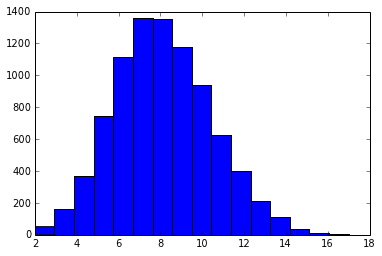

In [78]:
hist(lengths, bins=len(set(lengths)));

In [79]:
def pdist_good_turing_hack(counter, onecounter, base=1/26., prior=1e-8):
    """The probability of word, given evidence from the counter.
    For unknown words, look at the one-counts from onecounter, based on length.
    This gets ideas from Good-Turing, but doesn't implement all of it.
    prior is an additional factor to make unknowns less likely.
    base is how much we attenuate probability for each letter beyond longest."""
    N = sum(counter.values())
    N2 = sum(onecounter.values())
    lengths = map(len, [w for w in onecounter if onecounter[w] == 1])
    ones = Counter(lengths)
    longest = max(ones)
    return (lambda word: 
            counter[word] / N if (word in counter) 
            else prior * (ones[len(word)] / N2 or 
                          ones[longest] / N2 * base ** (len(word)-longest)))

# Redefine P1w
P1w = pdist_good_turing_hack(COUNTS1, COUNTS)

In [80]:
segment.cache.clear()
segment('thisisatestofsegmentationofaverylongsequenceofwords')

['this',
 'is',
 'a',
 'test',
 'of',
 'segment',
 'at',
 'i',
 'on',
 'of',
 'a',
 'very',
 'long',
 'sequence',
 'of',
 'words']

That was somewhat unsatisfactory.  We really had to crank up the prior, specifically because the process of running `segment` generates so many non-word candidates (and also because there will be fewer unknowns with respect to the billion-word `WORDS1` than with respect to the million-word `WORDS`).  It would be better to separate out the prior from the word distribution, so that the same distribution could be used for multiple tasks, not just for this one.

Now let's think for a short while about smoothing **bigram** counts.  Specifically, what if we haven't seen a bigram sequence, but we've seen both words individually?  For example, to evaluate P("Greenland") in the phrase "turn left at Greenland", we might have three pieces of evidence:

    P("Greenland")
    P("Greenland" | "at")
    P("Greenland" | "left", "at")
    
Presumably, the first would have a relatively large count, and thus large reliability, while the second and third would have decreasing counts and reliability.  With *interpolation smoothing* we combine all three pieces of evidence, with a linear combination:
    
$P(w_3 \mid w_1w_2) = c_1 P(w_3) + c_2 P(w_3 \mid w_2) + c_3 P(w_3 \mid w_1w_2)$

How do we choose $c_1, c_2, c_3$?  By experiment: train on training data, maximize $c$ values on development data, then evaluate on test data.
    
However, when we do this, we are saying, with probability $c_1$, that a word can appear anywhere, regardless of previous words.  But some words are more free to do that than other words.  Consider two words with similar probability:

In [81]:
print P1w('francisco')
print P1w('individuals')

7.73314623661e-05
7.72494966889e-05


They have similar unigram probabilities but differ in their freedom to be the second word of a bigram:

In [82]:
print [bigram for bigram in COUNTS2 if bigram.endswith('francisco')]

['San francisco', 'san francisco']


In [83]:
print [bigram for bigram in COUNTS2 if bigram.endswith('individuals')]

['are individuals', 'other individuals', 'on individuals', 'infected individuals', 'in individuals', 'where individuals', 'or individuals', 'which individuals', 'to individuals', 'both individuals', 'help individuals', 'more individuals', 'interested individuals', 'from individuals', '<S> individuals', 'income individuals', 'these individuals', 'about individuals', 'the individuals', 'among individuals', 'some individuals', 'those individuals', 'by individuals', 'minded individuals', 'These individuals', 'qualified individuals', 'certain individuals', 'different individuals', 'For individuals', 'few individuals', 'and individuals', 'two individuals', 'for individuals', 'between individuals', 'affected individuals', 'healthy individuals', 'private individuals', 'with individuals', 'following individuals', 'as individuals', 'such individuals', 'that individuals', 'all individuals', 'of individuals', 'many individuals']


Intuitively, words that appear in many bigrams before are more likely to appear in a new, previously unseen bigram. In *Kneser-Ney* smoothing (Reinhard Kneser, Hermann Ney) we multiply the bigram counts by this ratio.  But I won't implement that here, because The Count never covered it.

(10) One More Task: Secret Codes
===

Let's tackle one more task: decoding secret codes.  We'll start with the simplest of codes, a rotation cipher, sometimes called a shift cipher or a Caesar cipher (because this was state-of-the-art crypotgraphy in 100 BC).  First, a method to encode:

In [96]:
def rot(msg, n=13): 
    "Encode a message with a rotation (Caesar) cipher." 
    return encode(msg, alphabet[n:]+alphabet[:n])

def encode(msg, key): 
    "Encode a message with a substitution cipher." 
    table = string.maketrans(upperlower(alphabet), upperlower(key))
    return msg.translate(table) 

def upperlower(text): return text.upper() + text.lower()  

In [97]:
rot('This is a secret message.', 1)

'Uijt jt b tfdsfu nfttbhf.'

In [98]:
rot('This is a secret message.', 13)

'Guvf vf n frperg zrffntr.'

In [99]:
rot(rot('This is a secret message.'))

'This is a secret message.'

Now decoding is easy: try all 26 candidates, and find the one with the maximum Pwords:

In [101]:
def decode_rot(secret):
    "Decode a secret message that has been encoded with a rotation cipher."
    candidates = [rot(secret, i) for i in range(len(alphabet))]
    return max(candidates, key=lambda msg: Pwords(tokens(msg)))

In [102]:
msg = 'Who knows the answer?'
secret = rot(msg, 17)

print(secret)
print(decode_rot(secret))

Nyf befnj kyv rejnvi?
Who knows the answer?


Let's make it a tiny bit harder.  When the secret message contains separate words, it is too easy to decode by guessing that the one-letter words are most likely "I" or "a".  So what if the encode routine mushed all the letters together:

In [103]:
def encode(msg, key): 
    "Encode a message with a substitution cipher; remove non-letters." 
    msg = cat(tokens(msg))  ## Change here
    table = string.maketrans(upperlower(alphabet), upperlower(key))
    return msg.translate(table) 

Now we can decode by segmenting.  We change candidates to be a list of segmentations, and still choose the candidate with the best Pwords: 

In [104]:
def decode_rot(secret):
    """Decode a secret message that has been encoded with a rotation cipher,
    and which has had all the non-letters squeezed out."""
    candidates = [segment(rot(secret, i)) for i in range(len(alphabet))]
    return max(candidates, key=lambda msg: Pwords(msg))

In [105]:
msg = 'Who knows the answer this time? Anyone? Bueller?'
secret = rot(msg, 19)

print(secret)
print(decode_rot(secret))

pahdghplmaxtglpxkmablmbfxtgrhgxunxeexk
['who', 'knows', 'the', 'answer', 'this', 'time', 'anyone', 'bu', 'e', 'll', 'er']


In [109]:
candidates = [segment(rot(secret, i)) for i in range(len(alphabet))]

for c in candidates:
    print int(log10(Pwords(c))), ' '.join(c)

-123 p ah d g h p l max t g l p x km a bl mb f x t gr h g x un x e ex k
-133 q b i eh i q m n by u hm q y l n b cm n c g y u h s i h y vo y ff y l
-128 r c j f i jr no c z v in r z mo c d nod h z v it j i z w p z g g z m
-115 sd k g j k so p da w j os an p de op e i a w j u k j ax q ah h an
-144 t el h k l t p q e b x k p t b o q e f p q f j b x k v l k by r b ii b o
-145 u f m il m u q r f cy l qu c p r f g q r g k cy l wm l c z s c j j c p
-141 v g n j m n v r sg d z mr v d q sg h r s h l d z m x nm dat d k k d q
-39 who knows the answer this time anyone bu e ll er
-119 xi p l op x tu if b o t x f s u i j tu j n f b oz p of c v f mm f s
-151 y j q m p q y u v j g c p u y g t v j ku v k o g c pa q pg d w g n n g t
-151 z k r n q r z v w k h d q v z h u w k l v w l p h d q br q he x ho oh u
-97 also r saw x lie r w a iv x l m w x m q i er c s r if y i pp iv
-146 b mt p st b x y m j f s x b j w y m n x y n r j f sd t s j g z j q q j w
-137 c n u q tu cy z n k g ty c k x z no y z os k g 

What about a general substitution cipher?  The problem is that there are 26! substitution ciphers, and we can't enumerate all of them.  We would need to search through this space.  Initially make some guess at a substitution, then swap two letters; if that looks better keep going, if not try something else.  This approach solves most substitution cipher problems, although it can take a few minutes on a message of length 100 words or so.

(∞ and beyond) Where To Go Next
===

What to do next?  Here are some options:
    
- **Spelling correction**: Use bigram or trigram context; make a model of spelling errors/edit distance; go beyond edit distance 2; make it more efficient
- **Evaluation**: Make a serious test suite; search for best parameters (e.g. $c_1, c_2, c_3$)
- **Smoothing**: Implement Kneser-Ney and/or Interpolation; do letter *n*-gram-based smoothing
- **Secret Codes**: Implement a search over substitution ciphers
- **Classification**: Given a corpus of texts, each with a classification label, write a classifier that will take a new text and return a label.  Examples: spam/no-spam; favorable/unfavorable; what author am I most like; reading level.
- **Clustering**: Group data by similarity.  Find synonyms/related words.
- **Parsing**: Representing nested structures rather than linear sequences of words.  relations between parts of the structure.  Implicit missing bits.  Inducing a grammar.
- **Meaning**: What semantic relations are meant by the syntactic relations?
- **Translation**: Using examples to transform one language into another.
- **Question Answering**: Using examples to transfer a question into an answer, either by retrieving a passage, or by synthesizing one.
- **Speech**: Dealing with analog audio signals rather than discrete sequences of characters.

In [110]:
correct('cpgratulations')

'congratulations'